In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
MAINDIR = "./gdrive/My Drive/EA-test/"
import sys
sys.path.append(MAINDIR)
#Library created to facilitate the generation of clusters
from cluster import calc_clusters, calc_silhouette, plot_silhouette, calc_distorsion, plot_distorsion

df = pd.read_csv(MAINDIR + 'CompleteCSVDataset.csv')
df.shape

(17929, 74)

In [0]:
#We will exclude the value 'GK' in 'Preferred Positions' because the metrics for PlayerPlayingPositionData are all 0
df2 = df[~(df['Preferred Positions']  == 'GK')].copy()
#Selection of numerical variables
clm = df2.select_dtypes(exclude='object')
#We will only consider metrics related with the performance of the player, and drop the others
clm = clm.drop(columns=['ID','Age','Value','Wage']) 
clm = clm.columns.to_list()

In [4]:
# We will make the clusters with the top 20 player by 'Overall' and country, So we exclude any country with less than 20 observations
grp = df2.groupby('Nationality', as_index=False)['ID'].count()
country_slc = grp[grp.ID>19].Nationality.unique()
country_slc

array(['Albania', 'Algeria', 'Argentina', 'Australia', 'Austria',
       'Belgium', 'Bolivia', 'Bosnia Herzegovina', 'Brazil', 'Bulgaria',
       'Cameroon', 'Canada', 'Cape Verde', 'Chile', 'China PR',
       'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Czech Republic',
       'DR Congo', 'Denmark', 'Ecuador', 'Egypt', 'England', 'Finland',
       'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Hungary', 'Iceland', 'India', 'Italy', 'Ivory Coast', 'Jamaica',
       'Japan', 'Korea Republic', 'Kosovo', 'Mali', 'Mexico',
       'Montenegro', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'Northern Ireland', 'Norway', 'Paraguay', 'Peru', 'Poland',
       'Portugal', 'Republic of Ireland', 'Romania', 'Russia',
       'Saudi Arabia', 'Scotland', 'Senegal', 'Serbia', 'Slovakia',
       'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Tunisia', 'Turkey', 'Ukraine', 'United States', 'Uruguay',
       'Venezuela', 'Wales'], dtype=object)

In [0]:
#Select the top 20 players by 'Overall' and country and add the ID to a list
players = []
for c in country_slc:
  plys = df2[df2.Nationality == c][['ID','Overall']].sort_values('Overall',ascending=False)
  players += list(plys['ID'][:20])

In [0]:
#Filter rows by ID
df2 = df2[df2['ID'].isin(players)]

In [0]:
#A database of only countries is created to make clusters of them
df2 = df2.groupby('Nationality',as_index=False)[['Value','Wage']+clm].mean()

In [8]:
#Use of MinMaxScaler to have all values between 0 and 1
scaler = MinMaxScaler()
x = scaler.fit_transform(df2[clm])
x

array([[0.42175573, 0.4019802 , 0.47449068, ..., 0.40085288, 0.5232816 ,
        0.39699571],
       [0.66603053, 0.63564356, 0.74760578, ..., 0.75266525, 0.67405765,
        0.69313305],
       [0.94847328, 0.8970297 , 0.86000348, ..., 0.88486141, 0.75609756,
        0.85622318],
       ...,
       [0.75381679, 0.72673267, 0.8009751 , ..., 0.74626866, 0.73392461,
        0.7639485 ],
       [0.5629771 , 0.59009901, 0.50435313, ..., 0.50533049, 0.4767184 ,
        0.5193133 ],
       [0.57824427, 0.54257426, 0.64905102, ..., 0.53731343, 0.76274945,
        0.48712446]])

In [0]:
#Function to calculate hierarchical clusters from 2 to 30 groups
data_cl = calc_clusters(x, cluster_method = 'hierarchy')

In [0]:
#Calculate silhoutte average
#Return a column with the silhoutte average per cluster
data_cl = calc_silhouette(x, data_cl)

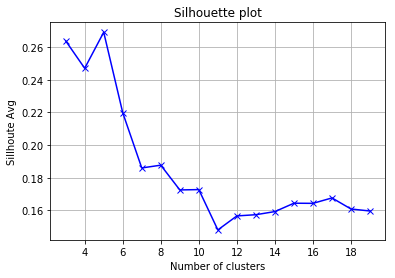

In [11]:
#Plot silhoutte average
plot_silhouette(data_cl, end= 20)

By the silhoutte average 5 is the optimal number of cluster

In [0]:
#Calculate distorsion for Elbow method
data_cl  = calc_distorsion(x, data_cl)

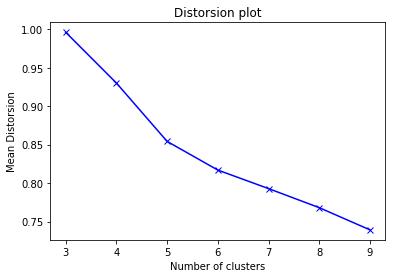

In [13]:
#Plot distorsion for Elbow method
plot_distorsion(data_cl, end=10)

There is not a clear optimal with the Elbow method

In [0]:
# Add clusters column to dataframe df2 (dataframe with only metrics by country)
b = pd.Series(data_cl.loc[5,'clusterList'],name = 'Cluster_countries')
df2 = pd.concat([df2,b], axis=1)

In [17]:
#Evaluate cluster metrics
df2.groupby('Cluster_countries',as_index=False).agg({'Nationality':'count','Value':'mean','Wage':'mean','Overall':'mean','Stamina':'mean'})

,Cluster_countries,Nationality,Value,Wage,Overall,Stamina
0,1,5,1.222500e+06,6630.000000,65.380000,66.970000
1,2,23,3.422022e+06,16678.260870,71.217391,70.778261
2,3,15,2.463467e+07,99293.333333,81.646667,77.270000
3,4,16,9.563906e+06,40803.125000,76.475000,74.950000
4,5,15,8.259667e+06,34216.666667,75.173333,74.913333


It seems that clusters are grouped from highest to lowest performance or average value, being 3 the highest performance, then 4, 5, 2 and 1

In [18]:
#Then, we change the cluster ID so that number 1 is the one with the highest performance and so on
df2.Cluster_countries.replace({3:1,4:2,5:3,2:4,1:5}, inplace=True)
df2.groupby('Cluster_countries',as_index=False).agg({'Nationality':'count','Value':'mean','Wage':'mean','Overall':'mean','Stamina':'mean'})

,Cluster_countries,Nationality,Value,Wage,Overall,Stamina
0,1,15,2.463467e+07,99293.333333,81.646667,77.270000
1,2,16,9.563906e+06,40803.125000,76.475000,74.950000
2,3,15,8.259667e+06,34216.666667,75.173333,74.913333
3,4,23,3.422022e+06,16678.260870,71.217391,70.778261
4,5,5,1.222500e+06,6630.000000,65.380000,66.970000


We can conclude that each group represents countries with top 20 players with similar performances, where the group 1 have the highest performance

In [0]:
#Save data frame of cluster
df2.to_csv(MAINDIR+'countryCLusters.csv',index=False)

In [0]:
# We want to add the cluster ID to the original dataframe uploaded in the notebook 'CompleteCSVDataset.csv'
#First we make the join with the players considered for the clusters
temp1 = df[df['ID'].isin(players)].merge(df2[['Nationality','Cluster_countries']], how = 'inner').copy()
#Then for others the value of cluster 0 is assigned
temp2 = df[~df['ID'].isin(players)].copy()
temp2['Cluster_countries'] = 0
df_final = temp1.append(temp2)

In [23]:
df_final.shape

(17929, 75)

In [0]:
df_final.to_csv(MAINDIR+'CompCsvCLusters.csv',index=False)